This model will explore 3 models: Slope One, Co-clustering and SVD and also ensemble a combination of these. Surprise, a sckit-based recommender system package, will be used to create these models. 

# Install Packages & Working Directory

In [2]:
#install surprise 
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195838 sha256=262e8d53afdd584bcd35cca90a7c8522ccd9fa6cc48d6c2473ed0fec1efc9fe6
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [3]:
## Import the necessary libraries

# Dataframe and arrays
import pandas as pd
import numpy as np

# Surprise models and functions 
from surprise import Dataset, Reader 
from surprise import SVD, SVDpp, SlopeOne, CoClustering
from surprise.model_selection import train_test_split
from surprise.accuracy import mse, rmse
from surprise import dump

# Time
from tqdm.auto import tqdm
import time 

# Plotting
import pylab as plt

In [4]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/DSA4212/DSA4212_Assignment2

/content/drive/MyDrive/DSA4212/DSA4212_Assignment2


# Prepare Data

The full training dataset is read into the environment

In [6]:
train_ds = pd.read_csv('assignment_2_ratings_train.csv')

In [7]:
train_ds.columns      #check the columns of the dataset

Index(['user_id', 'anime_id', 'rating'], dtype='object')

The training dataset needs to be processed as Surprise trainsets to be used for training Surprise models

In [8]:
reader = Reader(rating_scale=(1, 10))     

In [9]:
# Load the dataset into the Surprise format
train_data = Dataset.load_from_df(train_ds[['user_id', 'anime_id', 'rating']], reader)
# Split the dataset into training and testing sets
train, valid = train_test_split(train_data, test_size=0.2)

Note that a train-valid split is performed to evaluate the model performance throughout the experiments and conclude which of them perform better. 

The train set is also separately saved as a Surprise testset. This will be used when calculating the prediction on the train set. 

In [10]:
train_for_pred = train.build_testset()

# Individual Models

3 individual models are explored in this section as follows: 
<br> 1) Slope One (linear model with averages) 
<br> 2) SVD (Factor-based) 
<br> 3) Co-clustering (Factor-based)

Note that the training time for the each of the base models are also tracked

## Slope One

The first model tried is a Slope One model, which implements a form of linear model of the form `f(x) = x + b`, where `x` is the average ratings of each user and `b` is the average difference of the ratings of two animeas with common users. This model takes it a step further than the averages (as seen in the RecommendingWithAverages notebook) by taking into account the average differences of ratings that may occur. 

The model is fitted as follows 

In [ ]:
#initialize model 
slope_one = SlopeOne()

#fit model
start = time.time()
slope_one_fit = slope_one.fit(train)
end = time.time()

The training time of the model is as follows

In [ ]:
print("Training Time: ", end-start, "seconds")

Training Time:  85.49127340316772 seconds


The training and validation MSE are as follows 

In [ ]:
train_pred_slope1 = slope_one.test(train_for_pred)
mse(train_pred_slope1)

MSE: 1.2821


1.2821435809895236

In [ ]:
val_pred_slope1 = slope_one.test(valid)
mse(val_pred_slope1)

MSE: 1.4401


1.440055062464947

Slope One gives a higher validation accuracy than using just averages of movie and/or user (as seen in RecommendingWithAverages notebook)

## Co-Clustering

Co-clustering clusters both the users and animes into user-clusters and anime-clusters simultaneously, allowing us to obtain co-clusters of animes and users.

### Base

In [ ]:
#initialize model
base_cc = CoClustering()

#fit model 
start = time.time()
base_cc.fit(train)
end = time.time()

The following is the training time of the model

In [ ]:
print("Train Time: ", end-start, "seconds")       #the training time is somewhat longer 

Train Time:  147.98072624206543 seconds


The following are the trainging and validation MSE 

In [ ]:
train_pred_base_cc = base_cc.test(train_for_pred)  
mse(train_pred_base_cc)

MSE: 1.4011


1.4011044863828144

In [ ]:
valid_pred_base_cc = base_cc.test(valid)  
mse(valid_pred_base_cc)

MSE: 1.5016


1.501597912128916

The MSE is the highest of all the models attempted so far. However, let's see to what extent the MSE can be reduced via fine tuning. 

### Fine Tune

The following parameters of co-clustering can be fine tuned.
<br> 1) User Cluster Size 
<br> 2) Item Cluster Size 
<br> 3) Epochs

#### User Cluster Size

The default user cluster size is 3. The following values can be tried for the cluster sizes. 

In [ ]:
cltr_size = [3, 5, 7, 10]       #3 is default 
train_loss = []
val_loss = []

for trial in tqdm(range(len(cltr_size))):
  #initialize and fit model with current user cluster size trial  
  model = CoClustering(n_cltr_u = cltr_size[trial])
  model_fit = model.fit(train)

  #calculate training and validation predictions
  train_pred = model.test(train_for_pred)
  val_pred = model.test(valid)

  #calculate and append training and validation MSE 
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/4 [00:00<?, ?it/s]

RMSE: 1.1754
RMSE: 1.2167
RMSE: 1.1757
RMSE: 1.2230
RMSE: 1.1659
RMSE: 1.2166
RMSE: 1.1672
RMSE: 1.2202


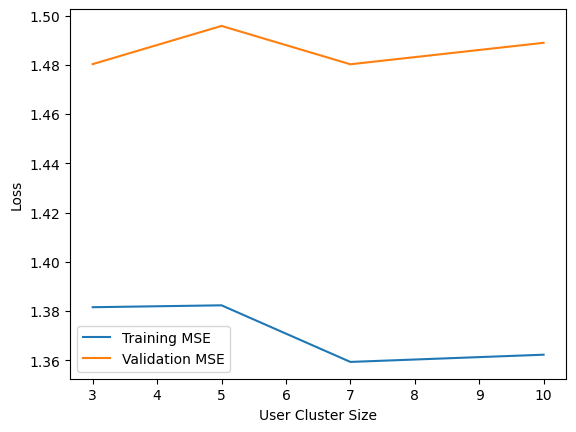

In [ ]:
plt.plot(cltr_size, train_loss, label='Training MSE')
plt.plot(cltr_size, val_loss, label='Validation MSE')
plt.xlabel('User Cluster Size')
plt.ylabel('Loss')
plt.legend()

The best cluster size is at 6-8. Hence, these values are tried below

In [ ]:
cltr_size = [6, 7, 8]
train_loss = []
val_loss = []

for trial in tqdm(range(len(cltr_size))): 
  #initialize and fit model with current user cluster size trial  
  model = CoClustering(n_cltr_u = cltr_size[trial])
  model_fit = model.fit(train)

  #calculate training and validation predictions
  train_pred = model.test(train.build_testset())
  val_pred = model.test(valid)

  #calculate and append training and validation MSE 
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE: 1.1676
RMSE: 1.2150
RMSE: 1.1886
RMSE: 1.2372
RMSE: 1.1648
RMSE: 1.2159


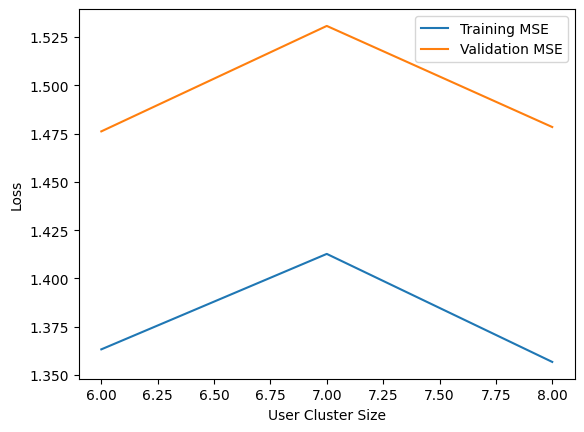

In [ ]:
plt.plot(cltr_size, train_loss, label='Training MSE')
plt.plot(cltr_size, val_loss, label='Validation MSE')
plt.xlabel('User Cluster Size')
plt.ylabel('Loss')
plt.legend()

#### Item Cluster Size

The default item cluster size is also 3. The following cluster sizes are tried 

In [ ]:
cltr_size = [3, 5, 7, 10]     #default is 3 
train_loss = []
val_loss = []

for trial in tqdm(range(len(cltr_size))): 
  #initialize and fit model with current item cluster size trial  
  model = CoClustering(n_cltr_i = cltr_size[trial])
  model_fit = model.fit(train)

  #calculate training and validation predictions
  train_pred = model.test(train_for_pred)
  val_pred = model.test(valid)

  #calculate and append training and validation MSE 
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/4 [00:00<?, ?it/s]

RMSE: 1.1745
RMSE: 1.2165
RMSE: 1.1774
RMSE: 1.2212
RMSE: 1.1695
RMSE: 1.2135
RMSE: 1.1690
RMSE: 1.2135


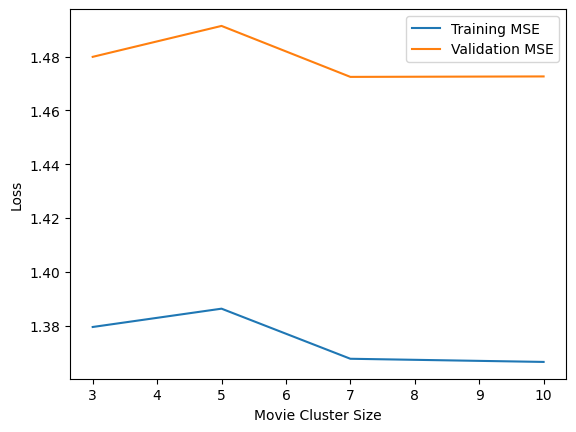

In [ ]:
plt.plot(cltr_size, train_loss, label='Training MSE')
plt.plot(cltr_size, val_loss, label='Validation MSE')
plt.xlabel('Movie Cluster Size')
plt.ylabel('Loss')
plt.legend()

The best cluster size seems to be between 6-8. Hence, these values are tried below. 

In [ ]:
cltr_size = [6, 7, 8]
train_loss = []
val_loss = []

for trial in tqdm(range(len(cltr_size))): 
  #initialize and fit model with current item cluster size trial  
  model = CoClustering(n_cltr_i = cltr_size[trial])
  model_fit = model.fit(train)

  #calculate training and validation predictions
  train_pred = model.test(train.build_testset())
  val_pred = model.test(valid)

  #calculate and append training and validation MSE 
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/3 [00:00<?, ?it/s]

RMSE: 1.1744
RMSE: 1.2200
RMSE: 1.1731
RMSE: 1.2170
RMSE: 1.1709
RMSE: 1.2164


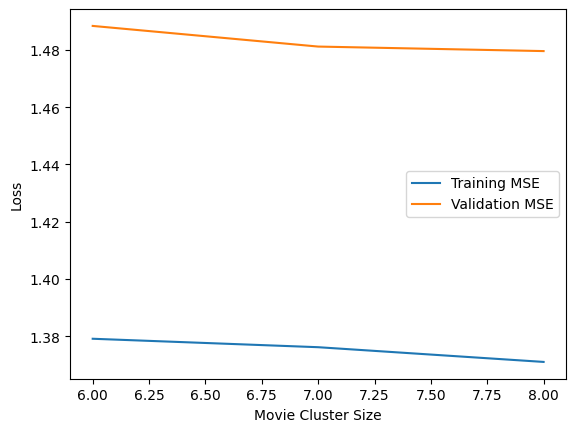

In [ ]:
plt.plot(cltr_size, train_loss, label='Training MSE')
plt.plot(cltr_size, val_loss, label='Validation MSE')
plt.xlabel('Movie Cluster Size')
plt.ylabel('Loss')
plt.legend()

8 is the best cluster size for items. This size will be use here onwards. 

#### Epochs

The default number of epochs is 20. The following ranges of epochs from 10-50 at steps of 10 is tried. The final training and validation loop of each model is stored to plot the approximate training and validation loss curves from 10-50 epochs.

In [ ]:
epochs = [10, 20, 30, 40, 50]    #20 is default
train_loss = []
val_loss = []

for trial in tqdm(range(len(epochs))): 
  #initialize and fit model with current epochs trial 
  model = CoClustering(n_epochs = epochs[trial], n_cltr_i = 8, n_cltr_u = 6, verbose = True)
  model_fit = model.fit(train)

  #calculate training and validation predictions
  train_pred = model.test(train.build_testset())
  val_pred = model.test(valid)

  #calculate and append training and validation MSE 
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
RMSE: 1.1671
RMSE: 1.2214
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
RMSE: 1.1607
RMSE: 1.2148
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 1

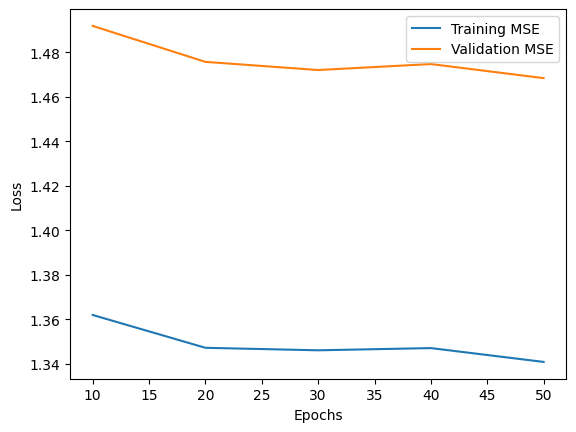

In [ ]:
plt.plot(epochs, train_loss, label='Training MSE')
plt.plot(epochs, val_loss, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

It seems that the validation MSE generally decreases for more epochs. Perhaps more than 50 epochs may even reduce the MSE further. Hence, values up to 80 epochs at step size of 10 are also tried below.  

In [ ]:
epochs = [60, 70, 80]    
train_loss = []
val_loss = []

for trial in tqdm(range(len(epochs))): 
  model = CoClustering(n_epochs = epochs[trial], n_cltr_i = 8, n_cltr_u = 6, verbose = True)
  model_fit = model.fit(train)
  train_pred = model.test(train.build_testset())
  val_pred = model.test(valid)
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/3 [00:00<?, ?it/s]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

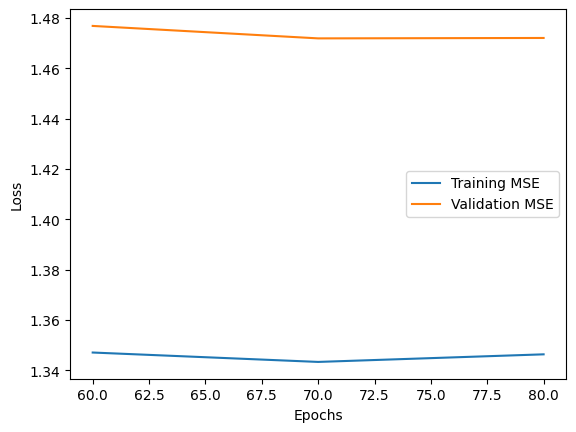

In [ ]:
plt.plot(epochs, train_loss, label='Training MSE')
plt.plot(epochs, val_loss, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

70 seems to be the best number of epochs before, to achieve lower MSE without overfitting. 

### Final

The best co-clustering model with the fine tuned paramters are as follows. 

In [11]:
final_cc = CoClustering(n_epochs = 70, n_cltr_i = 8, n_cltr_u = 6, verbose = True)
final_cc.fit(train)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [13]:
train_pred_final_cc = final_cc.test(train_for_pred)
mse(train_pred_final_cc)

MSE: 1.3489


1.3489323267559847

In [14]:
val_pred_final_cc = final_cc.test(valid)
mse(val_pred_final_cc)

MSE: 1.4723


1.4723344423458498

## SVD

The next model explored is SVD, a factor-based model that uses the following form of matrix factorization 

$$A = U\Sigma V^T$$

where A is the sparse matrix of user-item ratings, U is represents the relationship between users and latent factors, Σ represents the strength of each factor, and V represents the relationship between anime and latent factors

### Base

A base SVD model is fitted as follows

In [ ]:
#initialize model 
base_svd = SVD()

#fit model
start = time.time()
base_svd.fit(train)
end = time.time()

The training time is as follows

In [ ]:
print("Train Time: ", end-start, "seconds")     #the training time is less than slope one

Train Time:  73.31173038482666 seconds


The training and validation MSE are as follows

In [ ]:
train_pred_base_svd = base_svd.test(train_for_pred)  
mse(train_pred_base_svd)

MSE: 0.5356


0.5355527634242359

In [ ]:
valid_pred_base_svd = base_svd.test(valid)  
mse(valid_pred_base_svd)

MSE: 1.3707


1.3706803967156318

### Fine Tune

The following parameters can be fine tuned to further improve the MSE of the base model with default parameters
<br> 1) Usage of baselines 
<br> 2) Epochs 
<br> 3) Numer of factors 
<br> 4) Learning Rate 
<br> 5) Regularization

#### Baseline

By default, the SVD model also uses the bias/baselines of averages as shown below. 

Let's see if removing these baselines make any difference. Note that removing the baselines essentially makes the model function like a probabilistic matrix factorization.

In [ ]:
#initialize model 
svd_no_bias = SVD(biased = False)

#fit model
svd_no_bias.fit(train)

The training and validation MSE are as follows

In [ ]:
train_pred_svd_no_bias = svd_no_bias.test(train_for_pred)  
mse(train_pred_svd_no_bias)

MSE: 0.6951


0.6951451114150332

In [ ]:
valid_pred_svd_no_bias = svd_no_bias.test(valid)  
mse(valid_pred_svd_no_bias)

MSE: 1.5559


1.555876912448556

The validation accuracy significantly increased by not using baselines, hence the baselines should also be incorporated into the model

#### Epochs

The default number of epochs is 20. The following ranges of epochs from 10-50 at steps of 10 is tried. The final training and validation loop of each model is stored to plot the approximate training and validation loss curves from 10-50 epochs 

Note that all other paramters are kept at the defaults

In [ ]:
epochs = [10, 20, 30, 40, 50]     #default 20
train_loss = []           
val_loss = []

for trial in tqdm(range(len(epochs))): 
  #initialie and fit model with current epochs trial
  model = SVD(n_epochs = epochs[trial], verbose = True)
  model_fit = model.fit(train)
  
  #calculate training and validation predictions
  train_pred = model.test(train_for_pred)
  val_pred = model.test(valid)

  #calculate and append training and validation MSE 
  train_loss.append(mse(train_pred))
  val_loss.append(mse(val_pred))


  0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
MSE: 0.9803
MSE: 1.3679
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
MSE: 0.5352
MSE: 1.3722
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Pr

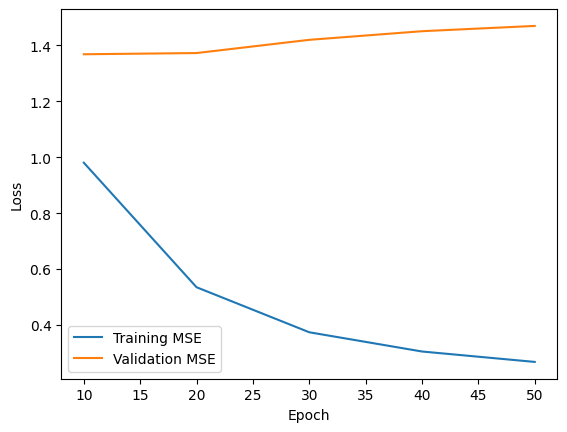

In [ ]:
plt.plot(epochs, train_loss, label='Training MSE')
plt.plot(epochs, val_loss, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

As shown by the plot, the model performs best at around 20 epochs, and after 30 epochs the model starts to overfit. The minimum MSE most likely occurs in between 10-30 epochs, hence the epochs in this range can be tried once again with a smaller step size of 5 as shown below

In [ ]:
epochs = [10, 15, 20, 25, 30]
train_loss = []
val_loss = []

for trial in tqdm(range(len(epochs))):
  #initialie and fit model with current epochs trial
  model = SVD(n_epochs = epochs[trial], verbose = True)
  model_fit = model.fit(train)
  
  #calculate training and validation predictions
  train_pred = model.test(train_for_pred)
  val_pred = model.test(valid)

  #calculate and append training and validation MSE 
  train_loss.append(mse(train_pred))
  val_loss.append(mse(val_pred))


  0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
MSE: 0.9776
MSE: 1.3674
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
MSE: 0.7040
MSE: 1.3540
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
MSE: 0.5349
MSE: 1.3723
Processing epoch 0
Processing epoch 1
Processing epoch 2
P

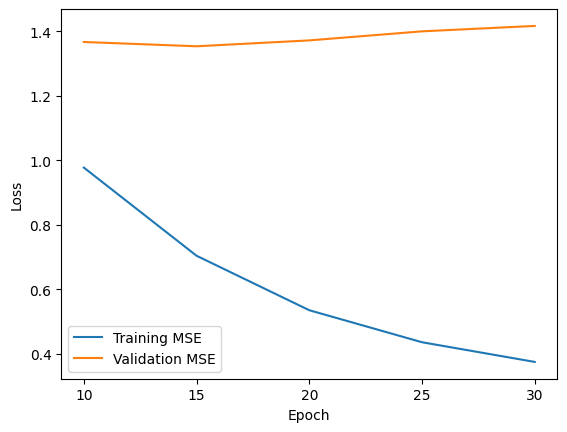

In [ ]:
plt.plot(epochs, train_loss, label='Training MSE')
plt.plot(epochs, val_loss, label='Validation MSE')
plt.xlabel('Epoch')
plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
plt.ylabel('Loss')
plt.legend()

The model achieves the lowest validation MSE at 15 epochs. This will the number of epochs used for SVD here onwards.

#### Factors

The difference in training and validation MSE still seems to be very high. Perhaps, the model may be too complicated due to the number of factors, which is set at 100 by default. Hence, a range of factors from 20-100 (at steps of 20 factors) can be experimented.

In [ ]:
factors = [20, 40, 60, 80, 100]     #default is 100
train_loss = []
val_loss = []

for trial in tqdm(range(len(factors))): 
  #initialize and fit model with current number of factors trial
  model = SVD(n_epochs = 15, n_factors = factors[trial], verbose = True)
  model_fit = model.fit(train)

  #calculate training and validation predictions 
  train_pred = model.test(train_for_pred)
  val_pred = model.test(valid)

  #calculate and append training and validation MSE
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 1.0294
RMSE: 1.1619
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.9658
RMSE: 1.1628
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.9150
RMSE: 1.1616
Processing epoch 0
Processing epoch 1
Processing epo

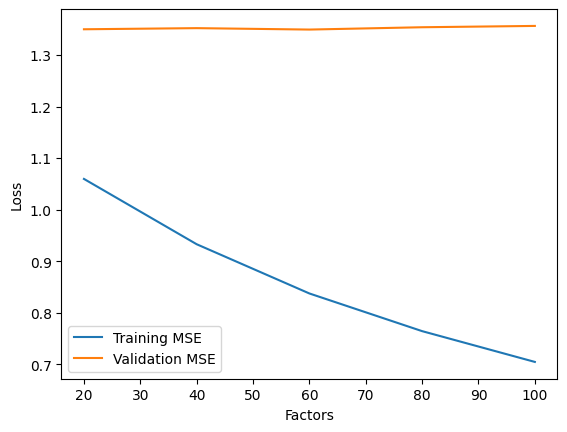

In [ ]:
plt.plot(factors, train_loss, label='Training MSE')
plt.plot(factors, val_loss, label='Validation MSE')
plt.xlabel('Factors')
plt.ylabel('Loss')
plt.legend()

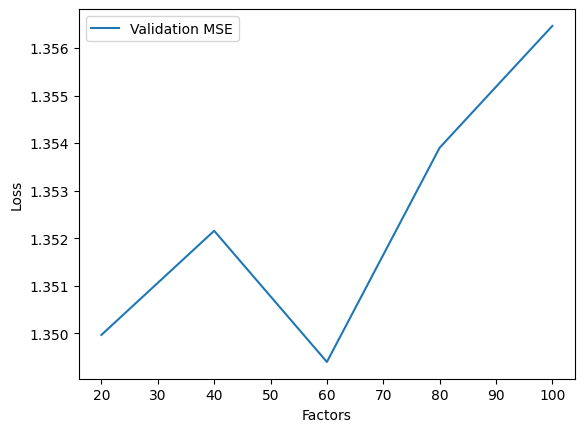

In [ ]:
plt.plot(factors, val_loss, label='Validation MSE')
plt.xlabel('Factors')
plt.ylabel('Loss')
plt.legend()

It seems that the number of factors does not significantly change MSE, however it is quite clear that it starts to rapidly increase after about 80 factors. The find the best number of factors the values of 50, 60, and 70 and tried again 

In [ ]:
factors = [50, 60, 70]
train_loss = []
val_loss = []

for trial in tqdm(range(len(factors))): 
  #initialize and fit model with current number of factors trial
  model = SVD(n_epochs = 15, n_factors = factors[trial], verbose = True)
  model_fit = model.fit(train)

  #calculate training and validation predictions 
  train_pred = model.test(train_for_pred)
  val_pred = model.test(valid)

  #calculate and append training and validation MSE
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/3 [00:00<?, ?it/s]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.9378
RMSE: 1.1617
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.9150
RMSE: 1.1623
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.8944
RMSE: 1.1624


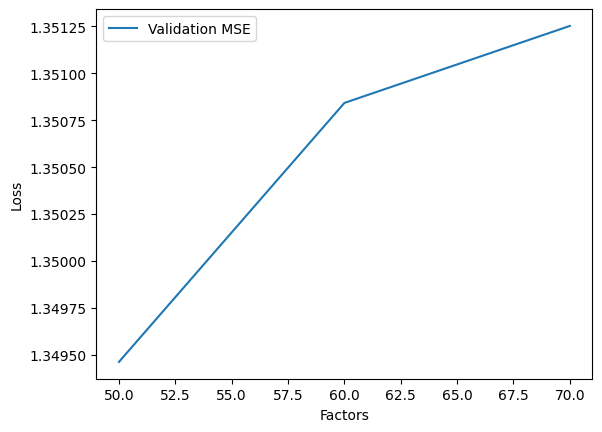

In [ ]:
plt.plot(factors, val_loss, label='Validation MSE')
plt.xlabel('Factors')
plt.ylabel('Loss')
plt.legend()

As shown by the plot, 50 is the best number of factors and hence will be used here onwards. 

#### Learning Rate

The learning rate of the model can also be experimented with to see if higher/lower learning rates can converge at better solutions. The default is 0.005 and the following values are experimented

Note that the best epochs and factors found so far are used. 

In [ ]:
lr = [1, 0.1, 0.01, 0.001, 0.0001]    #default 0.005, results above
train_loss = []
val_loss = []

for trial in tqdm(range(len(lr))): 
  #initialize and fit model with current learning rate trial
  model = SVD(n_epochs = 15, n_factors = 50, verbose = True, lr_all = lr[trial])
  model_fit = model.fit(train)

  #calculate training and validation predictions
  train_pred = model.test(train_for_pred)
  val_pred = model.test(valid)

  #calculate and append training and validation MSE 
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 2.6976
RMSE: 2.6956
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 2.6976
RMSE: 2.6956
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.7771
RMSE: 1.1901
Processing epoch 0
Processing epoch 1
Processing epo

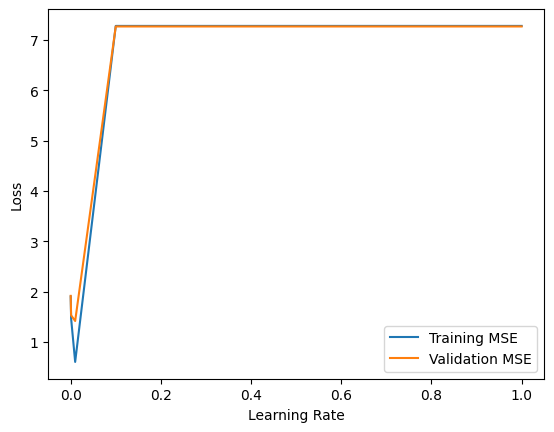

In [ ]:
plt.plot(lr, train_loss, label='Training MSE')
plt.plot(lr, val_loss, label='Validation MSE')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.legend()

The learning rate should clearly be less than 0.1. A learning rate of 0.01 results in the lowest MSE. Hence, the learning rate values in between 0.01 and 0.001 can once again be experimented as follows.

In [ ]:
lr = [0.007, 0.005, 0.003]    #default 0.005, results above
train_loss = []
val_loss = []

for trial in tqdm(range(len(lr))): 
  #initialize and fit model with current learning rate trial
  model = SVD(n_epochs = 15, n_factors = 50, verbose = True, lr_all = lr[trial])
  model_fit = model.fit(train)

  #calculate training and validation predictions
  train_pred = model.test(train.build_testset())
  val_pred = model.test(valid)

  #calculate and append training and validation MSE 
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/3 [00:00<?, ?it/s]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.8501
RMSE: 1.1698
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.9377
RMSE: 1.1590
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 1.0720
RMSE: 1.1739


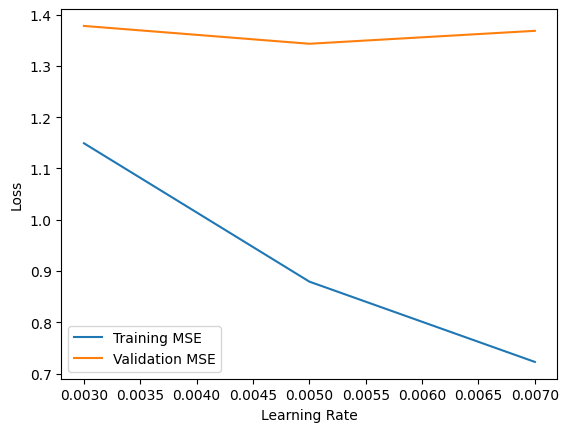

In [ ]:
plt.plot(lr, train_loss, label='Training MSE')
plt.plot(lr, val_loss, label='Validation MSE')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.legend()

The default learning rate (0.005) achieves the best validation MSE overall. Hence, the default learning rate will be used here onwards.

#### Regularization 

Finally, the regularization parameter can also be experimented with the following regulairzation values. (the default is at 0.02)

A value of zero is also tested to see if the model performs better with no regularization at all. 

In [ ]:
reg = [1, 0.1, 0.01, 0.001, 0]   #default is 0.02
train_loss = []
val_loss = []

for trial in tqdm(range(len(reg))): 
  #initialize and fit model with current regularization trial
  model = SVD(n_epochs = 15, n_factors = 50, verbose = True, reg_all = reg[trial])
  model_fit = model.fit(train)

  #calculate training and validation predictions 
  train_pred = model.test(train_for_pred)
  val_pred = model.test(valid)

  #calculate and append training and validation MSE
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/5 [00:00<?, ?it/s]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 1.3026
RMSE: 1.3144
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 1.1541
RMSE: 1.1919
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.8765
RMSE: 1.1801
Processing epoch 0
Processing epoch 1
Processing epo

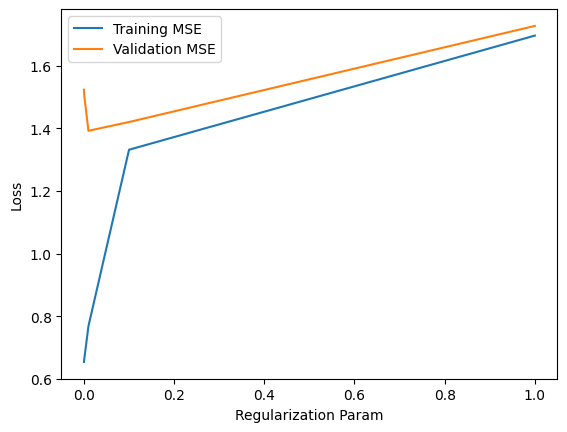

In [ ]:
plt.plot(reg, train_loss, label='Training MSE')
plt.plot(reg, val_loss, label='Validation MSE')
plt.xlabel('Regularization Param')
plt.ylabel('Loss')
plt.legend()

Some regularization is helpful. The best reguarlization value occurs between 0.01 and 0.1 (but mostly closer to 0.01). Hence, the following values are tried at smaller steps

In [ ]:
reg = [0.03, 0.02, 0.01]   #default is 0.02
train_loss = []
val_loss = []

for trial in tqdm(range(len(reg))): 
  model = SVD(n_epochs = 15, n_factors = 50, verbose = True, reg_all = reg[trial])
  model_fit = model.fit(train)
  train_pred = model.test(train.build_testset())
  val_pred = model.test(valid)
  train_loss.append(rmse(train_pred)**2)
  val_loss.append(rmse(val_pred)**2)


  0%|          | 0/3 [00:00<?, ?it/s]

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.9926
RMSE: 1.1558
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.9384
RMSE: 1.1603
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
RMSE: 0.8753
RMSE: 1.1794


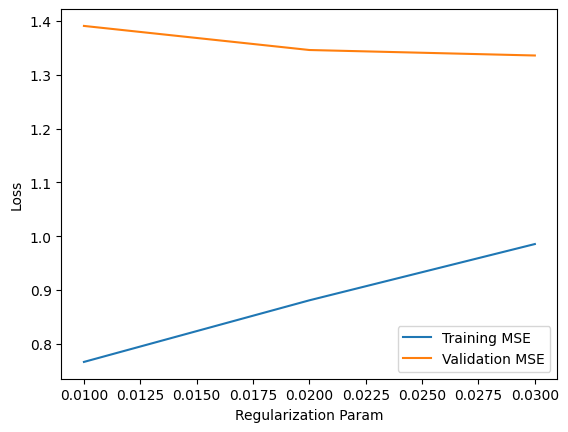

In [ ]:
plt.plot(reg, train_loss, label='Training MSE')
plt.plot(reg, val_loss, label='Validation MSE')
plt.xlabel('Regularization Param')
plt.ylabel('Loss')
plt.legend()

Evidently, a regularization parameter of 0.03 performs the best since it not reduces the validation MSE but also keeps the training and validation accuracy closer to each other. 

Overall, this section concludes that the best paramters for the SVD model are as follows: 
<br> 1) Usage of baselines: Yes (default)
<br> 2) Epochs: 15
<br> 3) Number of factors: 50
<br> 4) Learning Rate: 0.005 (default)
<br> 5) Regularization: 0.03

### Final

In [16]:
final_svd = SVD(n_epochs = 15, n_factors = 50, verbose = True, reg_all = 0.03)
final_svd.fit(train)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14


In [17]:
train_pred_final_svd = final_svd.test(train_for_pred)
mse(train_pred_final_svd)

MSE: 0.9888


0.9887607981579513

In [18]:
val_pred_final_svd = final_svd.test(valid)
mse(val_pred_final_svd)

MSE: 1.3359


1.3359385227685578

### SVD++

The SVD++ model is an extension of SVD that also factors in implicit ratings, i.e. that fact that a particular user rated a particular anime (regardless of what the actual rating is)

In [ ]:
#initialize the model 
base_svd_pp = SVDpp(cache_ratings = True)          

#fit the model
start = time.time()
base_svd_pp.fit(train)
end = time.time()

In [ ]:
print("Train Time: ", end-start, "seconds")     #the training time is the highest (significantly higher than the rest), despite caching

Train Time:  936.0916440486908 seconds


In [ ]:
train_pred_base_svd_pp = base_svd_pp.test(train_for_pred)  
mse(train_pred_base_svd_pp)

MSE: 0.9738


0.9737729788737366

In [ ]:
valid_pred_base_svd_pp = base_svd_pp.test(valid)  
mse(valid_pred_base_svd_pp)

MSE: 1.4398


1.4398359766977222

The performance of the base SVD++ is lower than the performance of the base SVD. Let's see how the performance changes by using the fine tuned parameters concluded for the SVD model  

In [ ]:
svd_pp = SVDpp(verbose = True, n_epochs = 15, n_factors = 50, reg_all = 0.03, cache_ratings = True)         
svd_pp_fit = svd_pp.fit(train)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14


In [ ]:
predictions = svd_pp.test(valid)
print("MSE: ", rmse(predictions)**2)

RMSE: 1.1770
MSE:  1.3853046197294843


The validation MSE decreased by changing the parameters, but is still not as low as SVD. Fine tuning SVD++ further may still not reduce the MSE as much as the lowest MSE of the SVD model. Furthermore, SVD++ takes significantly a longer time than SVD to train. Hence, the SVD++ model will not be used at all.

# Ensembling

From all the models attempted above, SVD was shown to be the best model found so far. However, it is possible that each model has it own strengths in making predictions. Hence, ensembling these models may produce an even higher performance. 

### Average

First, we will try to ensemble via averaging. The three models are initalized and fitted with their respective fine tuned parameters. 

In [ ]:
#build all 3 models
model1 = SVD(n_epochs = 15, n_factors = 50, reg_all = 0.03, verbose = True)
model2 = SlopeOne()
model3 = CoClustering(n_epochs = 70, n_cltr_u = 6, n_cltr_i = 8, verbose = True)

#fit all 3 models
model1.fit(train)
model2.fit(train)
model3.fit(train)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35


Each model is used to predict on the validation dataset 

In [ ]:
#Get model prediction son validation set 
val_pred1 = model1.test(valid)
val_pred2 = model2.test(valid)
val_pred3 = model3.test(valid)

In [ ]:
#Convert validation ratings to a numpy array 
val_rating1 = np.array(list(map(lambda row: row.est, val_pred1)))
val_rating2 = np.array(list(map(lambda row: row.est, val_pred2)))
val_rating3 = np.array(list(map(lambda row: row.est, val_pred3)))

The true rating of the validation data is also saved as a numpy aray 

In [ ]:
true_rating = np.array(list(map(lambda row: row[2], valid)))

In [ ]:
## save the ratings as npy file for future use 
np.save('true_rating.npy', true_rating)
np.save('val_rating1.npy', val_rating1)
np.save('val_rating2.npy', val_rating2)
np.save('val_rating3.npy', val_rating3)

Get Average Predictions as shown below

In [ ]:
import jax.numpy as jnp

Average on the top 2 models: SVD and slope one

In [ ]:
avg_pred1 = (val_rating1 + val_rating2)/2

In [ ]:
print("Valid MSE: ", jnp.mean((true_rating - avg_pred1)**2))

Valid MSE:  1.3496118


Average on the top 3 models: SVD, slope on, and co-clustering

In [ ]:
avg_pred2 = (val_rating1 + val_rating2 + val_rating3)/3

In [ ]:
print("Valid MSE: ", jnp.mean((true_rating - avg_pred2)**2))

Valid MSE:  1.3657371


Avering on the top 2 models has a higher MSE. However, it still does not beat the MSE of predicting using just SVD alone

### Weighted Average

Another ensembling method that could be tried is a weighted average method. The weights of the average can be optimized using gradient descent. 

The weighted average is optimized on the MSE of ensembling the training predictions. Hence, the training predictions will also need to be defined as numpy array. 

In [ ]:
#Get training predictions 
train_rating1 = model1.test(train.build_testset())
train_rating2 = model2.test(train.build_testset())
train_rating3 = model3.test(train.build_testset())

In [ ]:
#Convert training predictions to a numpy array 
train_rating1 = np.array(list(map(lambda row: row.est, train_rating1)))
train_rating2 = np.array(list(map(lambda row: row.est, train_rating2)))
train_rating3 = np.array(list(map(lambda row: row.est, train_rating3)))

In [ ]:
#Store true training ratings as a numpy array 
train_true_rating = np.array(list(map(lambda row: row[2], train.build_testset())))

In [ ]:
#Save as npy for future use
np.save('train_true_rating.npy', train_true_rating)
np.save('train_rating1.npy', train_rating1)
np.save('train_rating2.npy', train_rating2)
np.save('train_rating3.npy', train_rating3)

In [ ]:
#Load the validation ratings saved earlier  
true_rating = np.load('true_rating.npy')
val_rating1 = np.load('val_rating1.npy')
val_rating2 = np.load('val_rating2.npy')
val_rating3 = np.load('val_rating3.npy')

The gradient descent will be perfomred using JAX

In [ ]:
import jax

Define the loss function to be optimized as well as the weighted average predictions (using validation predictions) as follows. 

Note that the sum of weights is controlled at 1 to avoid estimations from overshooting and ensuring that the predicted rating values are between 1-10

The first set of gradient descent is performed using only SVD and Slope One models 

In [ ]:
def loss_avg(weight):
  train_pred = weight*train_rating1 + (1-weight)*train_rating2      #weighted average training prediction 
  return jnp.mean((train_pred-train_true_rating)**2)                #training MSE

#value and gradient of loss function 
loss_value_and_grad = jax.value_and_grad(loss_avg)      

In [ ]:
def avg_pred(weight):
  val_pred = weight*val_rating1 + (1-weight)*val_rating2          #weighted average validation prediction 
  return jnp.mean((val_pred-true_rating)**2)                      #validation MSE

In [ ]:
# Perform gradient descent 
c = 0.5               #initialize with average
niter = 20            #run for 20 iterations 
eta = 0.1             #learning rate

#store training, validation loss as well as the values of c
tr_loss_traj = []
val_loss_traj = []
c_traj = []


for i in range(niter):
  #perform gradient descent 
  v, g = loss_value_and_grad(c)
  val_loss = avg_pred(c)
  c = c - eta * g

  #store trajectory values
  c_traj.append(c)
  tr_loss_traj.append(v)
  val_loss_traj.append(val_loss)

In [ ]:
c         #final value of c 

Array(0.91432935, dtype=float32, weak_type=True)

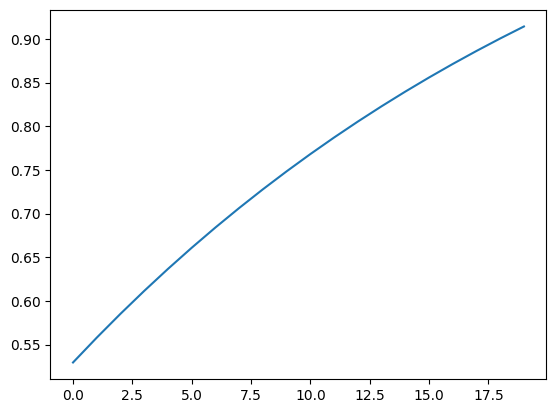

In [ ]:
plt.plot(c_traj)

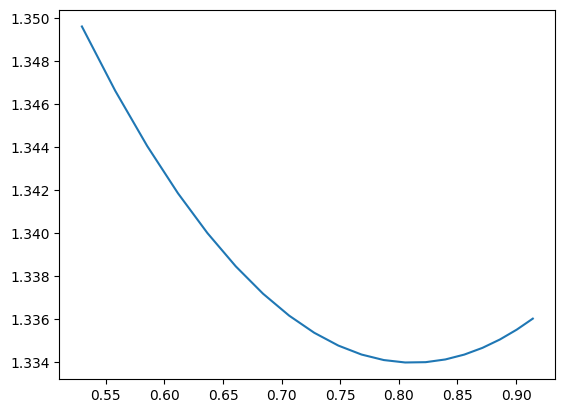

In [ ]:
plt.plot(c_traj, val_loss_traj)

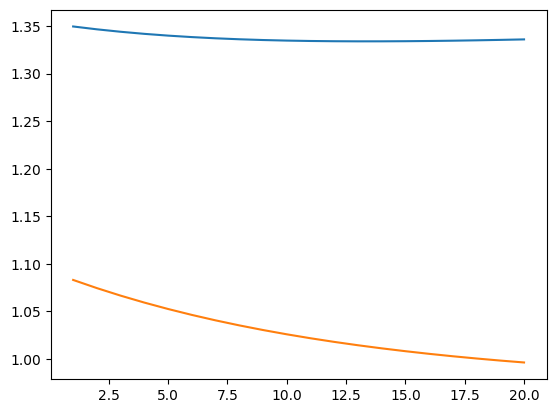

In [ ]:
plt.plot(np.arange(len(val_loss_traj))+1,val_loss_traj)
plt.plot(np.arange(len(val_loss_traj))+1,tr_loss_traj)

The best value of c is derived by finding the point where validation MSE is minimum as follows 

In [ ]:
best_c = c_traj[np.argmin(val_loss_traj)]

Get weighted average validation predictions using the best c value 

In [ ]:
weighted_avg_pred = best_c*val_rating1 + (1-best_c)*val_rating2

In [ ]:
print("Valid MSE: ", jnp.mean((true_rating - weighted_avg_pred)**2))

Valid MSE:  1.3339994


The validation MSE is lower than using just an average, however, still not as low as/comparable to fine tuned SVD. 

Let us also try to optimize the weights if we were to use three models using a similar method. The sum of weight is still controlled at 1

In [ ]:
#the loss function is same, but now the input of weights is a vector of two elements 
def loss_avg3(weights):
  train_pred = weights[0]*train_rating1 + weights[1]*train_rating2 + (1-weights[0]-weights[1])*train_rating3
  return jnp.mean((train_pred-train_true_rating)**2)

loss_value_and_grad = jax.value_and_grad(loss_avg3)

In [ ]:
#the loss function is same, but now the input of weights is a vector of two elements 
def avg_pred3(weights):
  val_pred =  weights[0]*val_rating1 + weights[1]*val_rating2 + (1-weights[0]-weights[1])*val_rating3
  return jnp.mean((val_pred-true_rating)**2)

In [ ]:
#the weights are initialized at equal values
#the iterations and eta are also the same 
curr_weight = [1/3, 1/3]
niter = 20
eta = 0.1

#the trajectory of training loss and validation loss as well as of the weights of 3 models are monitored 
tr_loss_traj = []
val_loss_traj = []
a_traj = []
b_traj = []
c_traj = []

for i in range(niter):
  #perform gradient descent 
  v, g = loss_value_and_grad(curr_weight)
  val_loss = avg_pred3(curr_weight)

  #move each weight the direction of gradient
  curr_weight[0] = curr_weight[0] - eta * g[0]
  curr_weight[1] = curr_weight[1] - eta * g[1]

  #keep track of weight trajectory
  a_traj.append(curr_weight[0])
  b_traj.append(curr_weight[1])
  c_traj.append(1-curr_weight[0]-curr_weight[1])

  #keep track of loss trajectory
  tr_loss_traj.append(v)
  val_loss_traj.append(val_loss)

In [ ]:
curr_weight     #weights returned at end of iteration 

[Array(0.8466629, dtype=float32, weak_type=True),
 Array(0.35205522, dtype=float32, weak_type=True)]

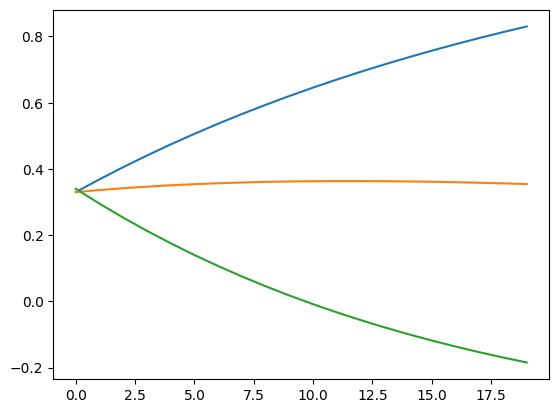

In [ ]:
#trajectory of all model weights
plt.plot(a_traj)
plt.plot(b_traj)
plt.plot(c_traj)

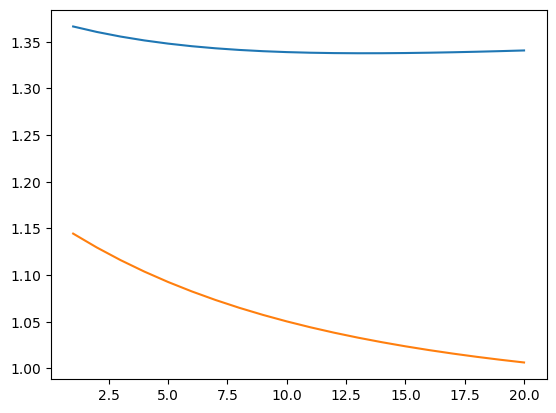

In [ ]:
plt.plot(np.arange(len(val_loss_traj))+1,val_loss_traj)
plt.plot(np.arange(len(val_loss_traj))+1,tr_loss_traj)

Extract the best weights by finding the point where the validation MSE is the least 

In [ ]:
best_a = a_traj[np.argmin(val_loss_traj)]
best_b = b_traj[np.argmin(val_loss_traj)]
best_c =  c_traj[np.argmin(val_loss_traj)]
print(best_a, best_b, best_c)

0.6932259 0.3632463 -0.056472212


Calculate and evaluate the weighted average predictions using the best weights 

In [ ]:
weighted_avg_pred2 = best_a*val_rating1 + best_b*val_rating2 + best_c*val_rating3

In [ ]:
print("Valid MSE: ", jnp.mean((true_rating - weighted_avg_pred2)**2))

Valid MSE:  1.3376684


The MSE of the weighted average using 3 models is slightly higher than if we were to only use 2 models (without Co-clustering). In fact, the weight of Co-Clustering is also negative. Hence, it is better to only use 2 models for weighted average ensembling

When comparing the results of ensembling to fine tuned SVD (individual), the MSEs are almost comparable. Since, SVD is a simpler and faster model than ensembling, with an MSE that is slightly higher, fine tuned SVD is concluded to perform the best in this notebook. 